This notebook will assess the model on stationary image using test dataset of complete different nature from how the model was trained on. 

In [1]:
import pickle

import os
import cv2
import mediapipe as mp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
os.chdir('/Users/trangdang/Desktop/University of Chicago/5. Fall 2023/Capstone/Capstone II')

In [3]:
labels_dict = {0: 'A', 1: 'B', 2: 'C',
               3: 'D', 4: 'E', 5: 'F',
               6: 'G', 7: 'H', 8: 'I',
               9: 'J', 10: 'K', 11: 'L',
               12: 'M', 13: 'N', 14: 'O', 
               15: 'P', 16: 'Q', 17: 'R', 
               18: 'S', 19: 'T', 20: 'U', 
               21: 'V', 22: 'W', 23: 'X', 
               24: 'Y', 25: 'Z'}

### Import model

In [4]:
model_dict = pickle.load(open('./Flipping Hand/model.p', 'rb'))
model = model_dict['model']

### Set up hand recognizer Mediapipe 

In [5]:
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles

hands = mp_hands.Hands(static_image_mode=True, min_detection_confidence=0.3)

### Use model to do prediction 

In [6]:
prediction_val = []
prediction_conf = []
actual_val = []
hand_type_list = []

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


### Import test dataset

In [7]:
test_data_path = './data_test'

test_data_class_list = os.listdir(test_data_path)
test_data_class_list = [item for item in test_data_class_list if item != '.DS_Store']
test_data_class_list = sorted(test_data_class_list)

# Get one class instance (for...)
for test_data_class_instance_name in test_data_class_list: 
    print(f"Class: {test_data_class_instance_name}")
    test_data_class_instance_path = os.path.join(test_data_path, test_data_class_instance_name)
    test_data_class_instance_image_list = os.listdir(test_data_class_instance_path)
    test_data_class_instance_image_list = [item for item in test_data_class_instance_image_list if item != '.DS_Store']
    test_data_class_instance_image_list = sorted(test_data_class_instance_image_list)
    
    # Get one image instance (for...)
    for image_name in test_data_class_instance_image_list:
        image_path = os.path.join(test_data_path, test_data_class_instance_name, image_name)
        image = cv2.imread(image_path)

        # Process image 
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        H, W, _ = image.shape

        # Process hand 
        results = hands.process(image)
        if results.multi_hand_landmarks:
            # Hand property 
            hand_classification = results.multi_handedness
            hand_label = hand_classification[0].classification[0].label

            # Prediction process 
            for hand_landmarks in results.multi_hand_landmarks:
                # Put down here to fix multiple hands detected problems
                data_aux = []
                x_ = []
                y_ = []

                for i in range(len(hand_landmarks.landmark)):
                    x = hand_landmarks.landmark[i].x
                    y = hand_landmarks.landmark[i].y

                    x_.append(x)
                    y_.append(y)

                for i in range(len(hand_landmarks.landmark)):
                    x = hand_landmarks.landmark[i].x
                    y = hand_landmarks.landmark[i].y
                    data_aux.append(x - min(x_))
                    data_aux.append(y - min(y_))

                x1 = int(min(x_) * W) - 10
                y1 = int(min(y_) * H) - 10

                x2 = int(max(x_) * W) - 10
                y2 = int(max(y_) * H) - 10

                prediction = model.predict([np.asarray(data_aux)])
                predicted_character = labels_dict[int(prediction[0])]

                prediction_proba = model.predict_proba([np.asarray(data_aux)])
                prediction_proba_pct = round(max(prediction_proba[0]) * 100,2)

                actual_character = image_name.split("_")[0]

        # Record results
        hand_type_list.append(hand_label)
        prediction_val.append(predicted_character)
        prediction_conf.append(prediction_proba_pct)
        actual_val.append(actual_character)

Class: 0
Class: 1
Class: 10
Class: 11
Class: 12
Class: 13
Class: 14
Class: 15
Class: 16
Class: 17
Class: 18
Class: 19
Class: 2
Class: 20
Class: 21
Class: 22
Class: 23
Class: 24
Class: 25
Class: 3
Class: 4
Class: 5
Class: 6
Class: 7
Class: 8
Class: 9


### Display actual vs prediction heatmap

In [8]:
from sklearn.metrics import confusion_matrix
color_palette = "Blues"

In [9]:
conf_matrix = confusion_matrix(actual_val, prediction_val)
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100

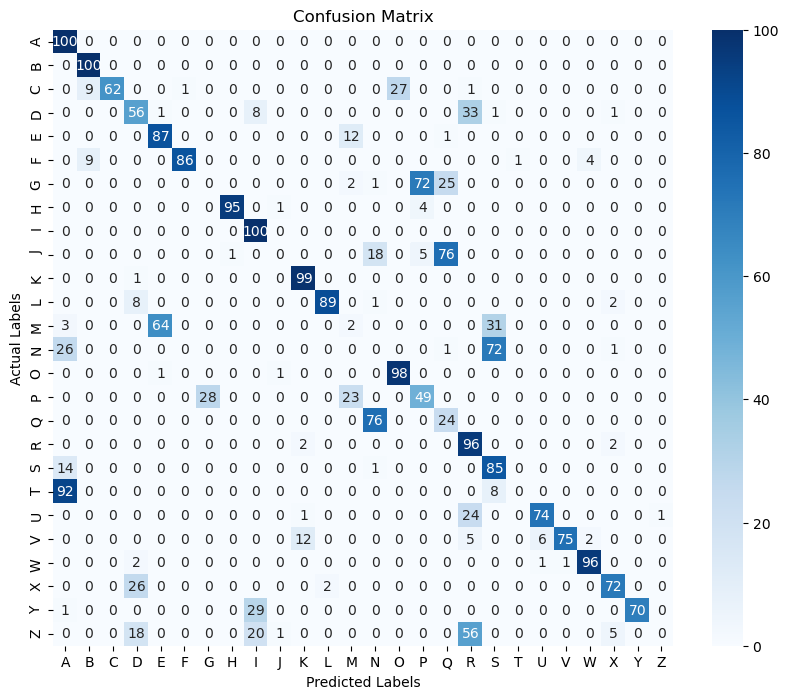

In [10]:
# Create a heatmap using Seaborn
plt.figure(figsize=(10, 8))
labels = list(labels_dict.values())
sns.heatmap(conf_matrix, annot=True, fmt=".0f", 
            cmap = color_palette, xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.title('Confusion Matrix')
plt.show()